In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from ISLP import load_data
from ISLP.torch import SimpleDataModule, SimpleModule,ErrorTracker, rec_num_workers
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

from pytorch_lightning import Trainer, LightningDataModule, LightningModule
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import RMSprop
from torch import nn

from torchmetrics import MeanAbsoluteError , R2Score, Accuracy


In [2]:
def cost_derivative(beta):
    return np.cos(beta) + 1 / 10

def cost(beta):
    return np.sin(beta) + beta / 10

def gradient_descent(beta_init):
    beta_old = beta_init
    cost_old = cost(beta_old)
    eps = np.Inf 
    
    betas = [beta_old]
    costs = [cost_old]
    
    while eps > 0.00001:
        beta_new = beta_old - 0.1 * cost_derivative(beta_old)
        cost_new = cost(beta_new)
        
        betas.append(beta_new)
        costs.append(cost_new)
        
        eps = abs(cost_new - cost_old)
        cost_old = cost_new
        beta_old = beta_new
    
    return beta_new

print(gradient_descent(2.3))
print(gradient_descent(1.4))

    

4.603167257372122
-1.66229520235029


Text(0, 0.5, 'y')

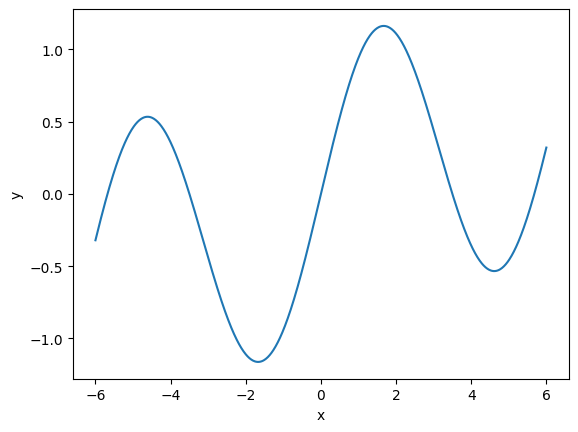

In [3]:
fig, ax = plt.subplots()
x = np.linspace(-6, 6, num=1000)
y = np.sin(x) + x / 10
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [4]:
df = load_data("default")
y = df.pop("default")
y = np.where(y == "Yes", 1, 0)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [7]:
one_hot_encoder = ColumnTransformer([("one_hot_encoder", OneHotEncoder(drop="first", sparse_output=False) , ["student"])], remainder="passthrough")
scaler = StandardScaler()

cross_validated_pipeline =  Pipeline(
    [
        ("one_hot_encoder", one_hot_encoder), 
        ("scaler", scaler),
        ("logistic_regression", LogisticRegressionCV(cv = KFold(5), scoring="roc_auc"))
    ]
)



In [8]:
cross_validated_pipeline.fit(X_train, y_train)

Pipeline(steps=[('one_hot_encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['student'])])),
                ('scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                      scoring='roc_auc'))])

In [9]:
preds = cross_validated_pipeline.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, preds)


0.978370320644448

In [10]:
class DefaultDataModule(LightningDataModule):

    def __init__(self, train_dataset, validation_dataset, test_dataset,
                 batch_size=32, num_workers=4, persistent_workers=True,
                 seed=0):

        super(DefaultDataModule, self).__init__()


        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.test_dataset = test_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.persistent_workers = persistent_workers and num_workers > 0
        self.seed = seed

    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          shuffle=True,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          persistent_workers=self.persistent_workers)

    def val_dataloader(self):
        return DataLoader(self.validation_dataset,
                          shuffle=False,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          persistent_workers=self.persistent_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          persistent_workers=self.persistent_workers)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=len(self.test_dataset),
                          num_workers=self.num_workers,
                          persistent_workers=self.persistent_workers)


class DefaultModule(LightningModule):

    """
    A simple `pytorch_lightning` module for regression problems.
    """

    def __init__(self, input_size):

        super(DefaultModule, self).__init__()

        
        self.flatten = nn.Flatten() 
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 1), 
#             nn.ReLU(), 
#             nn.Dropout(0.4), 
#             nn.Linear(10, 1)
        )

        self.loss = nn.BCEWithLogitsLoss()
        self._optimizer = RMSprop(self.parameters(), lr=0.001)
        self.metrics = {"accuracy": Accuracy("binary")}
        self.pre_process_y_for_metrics=lambda y: y.int()
        self.on_epoch = True

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = self.loss(preds, y)
        self.log("train_loss",
                 loss,
                 on_epoch=self.on_epoch,
                 on_step=False)

        y_ = self.pre_process_y_for_metrics(y)
        for _metric in self.metrics.keys():
            self.log(f"train_{_metric}",
                     self.metrics[_metric](preds, y_),
                     on_epoch=self.on_epoch)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch

    def validation_step(self, batch, batch_idx):
        x, y = batch

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return y, self.forward(x)

    def configure_optimizers(self):
        return self._optimizer


In [11]:
X_train_with_dummies = one_hot_encoder.fit_transform(X_train)
X_train_with_dummies = scaler.fit_transform(X_train_with_dummies)
X_test_with_dummies = one_hot_encoder.transform(X_test)
X_test_with_dummies = scaler.transform(X_test_with_dummies)

In [12]:
X_train_t = torch.tensor(X_train_with_dummies.astype(np.float32))
X_test_t = torch.tensor(X_test_with_dummies.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))


tensor_train = TensorDataset(X_train_t, y_train_t)
tensor_test = TensorDataset(X_test_t, y_test_t)



In [13]:
default_data_module = DefaultDataModule(tensor_train, tensor_test, tensor_test)

In [14]:
default_module = DefaultModule(X_train_t.shape[1])

In [17]:
default_trainer = Trainer(
    deterministic=True, max_epochs=20,
    log_every_n_steps=5, callbacks=[ErrorTracker()]
)
default_trainer.fit(default_module, datamodule=default_data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | flatten    | Flatten           | 0     
1 | sequential | Sequential        | 4     
2 | loss       | BCEWithLogitsLoss | 0     
-------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [479]:
default_trainer.test(default_module, datamodule=default_data_module)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.968500018119812
        test_loss           0.1681278795003891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1681278795003891, 'test_accuracy': 0.968500018119812}]

In [480]:
default_module.eval()

DefaultModule(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
  (loss): BCEWithLogitsLoss()
)

In [481]:
preds = default_module(X_train_t).detach().numpy()
preds.max()

9.50509

In [482]:
roc_auc_score(y_train, preds)

0.569409228115567